# Along-coast wind

In this notebook, I am testing the procedure for interpolating wind onto coastal locations, then projecting wind vectors onto the upcoast coastline direction.

This started from script `shelf_transport/calc_wind_angle.py`.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tracpy
import matplotlib.tri as mtri
from scipy.spatial import Delaunay
import cmocean.cm as cmo
import os
import matplotlib as mpl
import scipy.stats
import xarray as xr
mpl.rcParams.update({'font.size': 14})


In [3]:
# load in grid
proj = tracpy.tools.make_proj('nwgom-pyproj')
grid = tracpy.inout.readgrid('../../grid.nc', proj)
lon_rho = grid.lon_rho[1:-1,1:-1]
lat_rho = grid.lat_rho[1:-1,1:-1]
x_rho, y_rho = proj(lon_rho, lat_rho)
angle = grid.angle_rho[1:-1,1:-1]  # theta to rotate wind vectors

# load in coastline as clicked in by coast boxes
outerpathxy = np.load('../calcs/coastpaths.npz', encoding='latin1')['outerpathg'].item()
# # x, y pts for path closest to land
# xcoast = outerpathxy.vertices[:343,0]; ycoast = outerpathxy.vertices[:343,1]
# x, y pts for path farther from land
xgcoast = outerpathxy.vertices[343:-2,0]; ygcoast = outerpathxy.vertices[343:-2,1]
# also flipping so go from MX to LA in order
xgcoast = xgcoast[::-1]; ygcoast = ygcoast[::-1]

# convert from grid coords to xy
xcoast, ycoast, _ = tracpy.tools.interpolate2d(xgcoast, ygcoast, grid, 'm_ij2xy')

# convert from grid coords to ll to save
loncoast, latcoast, _ = tracpy.tools.interpolate2d(xgcoast, ygcoast, grid, 'm_ij2ll')

## Make coastline vectors

Coastline vectors are unit vectors and are set up such that:
* If the land is oriented from west to east with no north-south component, `veccoast=[1,0]`
* If the land is oriented from east to west with no north-south component, `veccoast=[-1,0]`
* If the land is oriented from south to north with no east-west component, `veccoast=[0,1]`
* If the land is oriented from north to south with no east-west component, `veccoast=[0,-1]`

* In Mexico, `veccoast` should be [+,+]
* In the south part of Texas, `veccoast` should be [-,+]
* For most of Texas, `veccoast` should be [+,+]
* For west Louisiana, `veccoast` should be [+,-]
* On the west side of Mississippi delta, `veccoast` should be [0,-]
* On the east side of Mississippi delta, `veccoast` should be [-,0]

The following plots make it look like the coastline vectors are correct.

In [13]:
# make upcoast-pointing vector from coast coordinates on either side of given pt
# goes from MX to LA. + is upcoast and toward land.
veccoast = np.zeros((xcoast.size, 2))*np.nan
veccoast[1:-1,0] = (xcoast[2:] - xcoast[0:-2])
veccoast[1:-1,1] = (ycoast[2:] - ycoast[0:-2])
# unit vector: normalize
veccoast /= np.sqrt(veccoast[:,0]**2 + veccoast[:,1]**2)[:,np.newaxis]

# calculate vector that is rotated 90 degrees off from coast direction
# cos(90) = 0, sin(90) = 1
veccoast90 = np.vstack((veccoast[:,0]*0 - veccoast[:,1]*1,
                       veccoast[:,0]*1 + veccoast[:,1]*0)).T


# along-coast distance
dtemp = np.sqrt((xcoast[1:] - xcoast[:-1])**2 + (ycoast[1:] - ycoast[:-1])**2)
dist = dtemp.cumsum()
dist /= 1000 # convert to km
dist = np.hstack((0, dist))


In [142]:
# save
vecname = 'calcs/coast_vectors.npz'
np.savez(vecname, veccoast=veccoast, veccoast90=veccoast90, dist=dist, 
         xgcoast=xgcoast, ygcoast=ygcoast, loncoast=loncoast, latcoast=latcoast)

The arrows `veccoast` and `veccoast90` should be perpendicular.

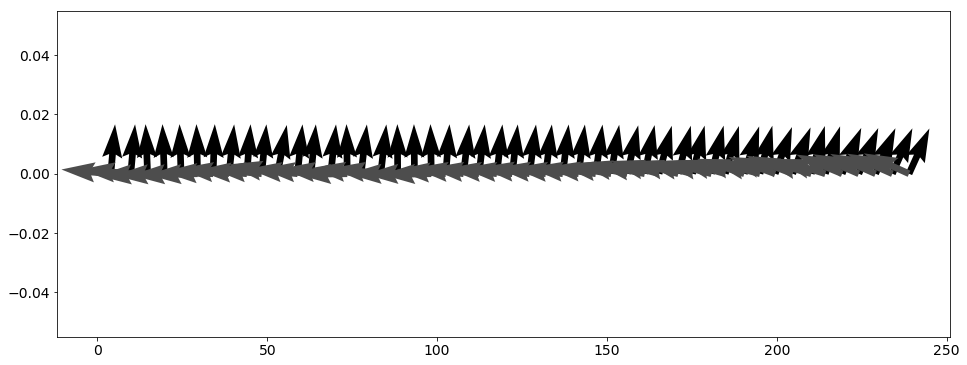

In [122]:
fig, axes = plt.subplots(1,1, figsize=(16,6), sharey=True)

dd = 50
# along-coastline vectors
axes.quiver(dist[:dd], np.zeros_like(dist[:dd]), veccoast[:dd,0], veccoast[:dd,1]);
# across-coastline vectors
axes.quiver(dist[:dd], np.zeros_like(dist[:dd]), veccoast90[:dd,0], veccoast90[:dd,1], color='0.3');


Their dot product should be zero:

In [129]:
np.nansum(np.dot(veccoast, veccoast90.T).diagonal())

5.8182578238525338e-17

Words

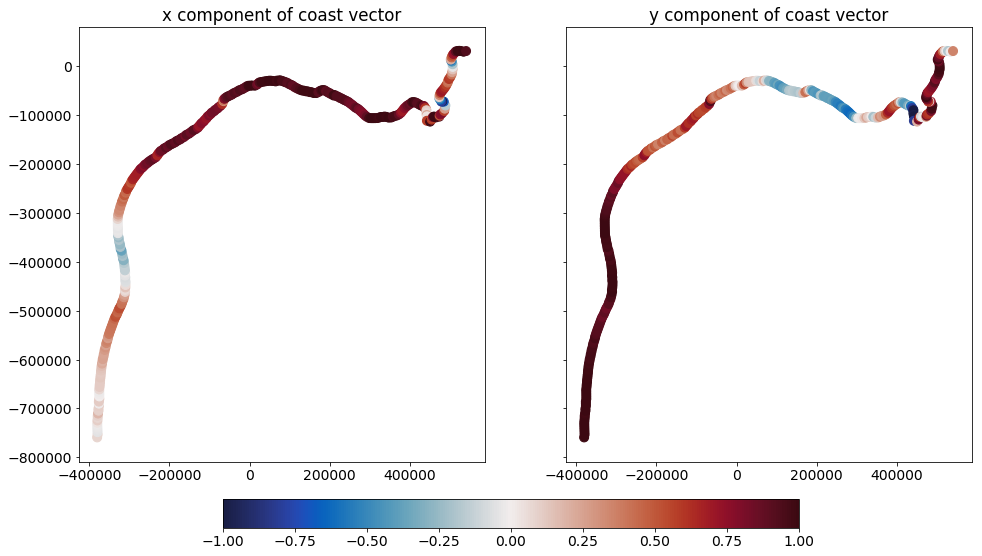

In [55]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
axes[0].scatter(xcoast, ycoast, c=veccoast[:,0], s=80, cmap=cmo.balance, vmin=-1, vmax=1)
axes[0].set_title('x component of coast vector')
mappable = axes[1].scatter(xcoast, ycoast, c=veccoast[:,1], s=80, cmap=cmo.balance, vmin=-1, vmax=1)
axes[1].set_title('y component of coast vector')
cax = fig.add_axes([0.25,0.01,0.5,0.05])
fig.colorbar(mappable, cax=cax, orientation='horizontal')

## Wind vectors

In [6]:
def rot2d(x, y, ang):
    '''rotate vectors by geometric angle'''
    xr = x*np.cos(ang) - y*np.sin(ang)
    yr = x*np.sin(ang) + y*np.cos(ang)
    return xr, yr

In [166]:
# read in wind from model output
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
m = xr.open_dataset(loc)
dates = m['ocean_time'].sel(ocean_time='2006')
date = dates[0]

# U and V wind speed on rho grid but without ghost cells
# u, v are along and across-shore
u = m.Uwind.sel(ocean_time=date).isel(eta_rho=slice(1,-1), xi_rho=slice(1,-1))
v = m.Vwind.sel(ocean_time=date).isel(eta_rho=slice(1,-1), xi_rho=slice(1,-1))

# rotate u, v to be east/north/Cartesian so that I can project properly to coast vectors
u, v = rot2d(u, v, angle)

# interpolate wind information onto outerpathxy vertices
# Triangulation for grid space to curvilinear space, but 1:-1 in x,y for rho grid
pts = np.column_stack((x_rho.flatten(), y_rho.flatten()))
tess = Delaunay(pts)
tri = mtri.Triangulation(x_rho.flatten(), y_rho.flatten(), tess.simplices.copy())
fu = mtri.LinearTriInterpolator(tri, u.data.flatten())
fv = mtri.LinearTriInterpolator(tri, v.data.flatten())
ucoast = fu(xcoast, ycoast)  # x-direction wind, at locations along coast
vcoast = fv(xcoast, ycoast)  # y-direction wind, at locations along coast


In [130]:
# make vector of wind
w = np.vstack((ucoast, vcoast))

# dot product of the two vectors: gives size of along-shore component
walong = np.dot(veccoast, w).diagonal()

wacross = np.dot(veccoast90, w).diagonal()


Projected wind vectors should have the following behavior, keeping in mind that wind is not normalized so stronger wind is stronger:
When wind arrows are:
* more aligned with coast and upcoast-pointing and stronger, `walong` should be more positive
* downcoast-pointing and strong, `walong` negative
* pointing to the side and toward land, `wacross` should be positive
* pointing to the side and away from land, `wacross` should be negative


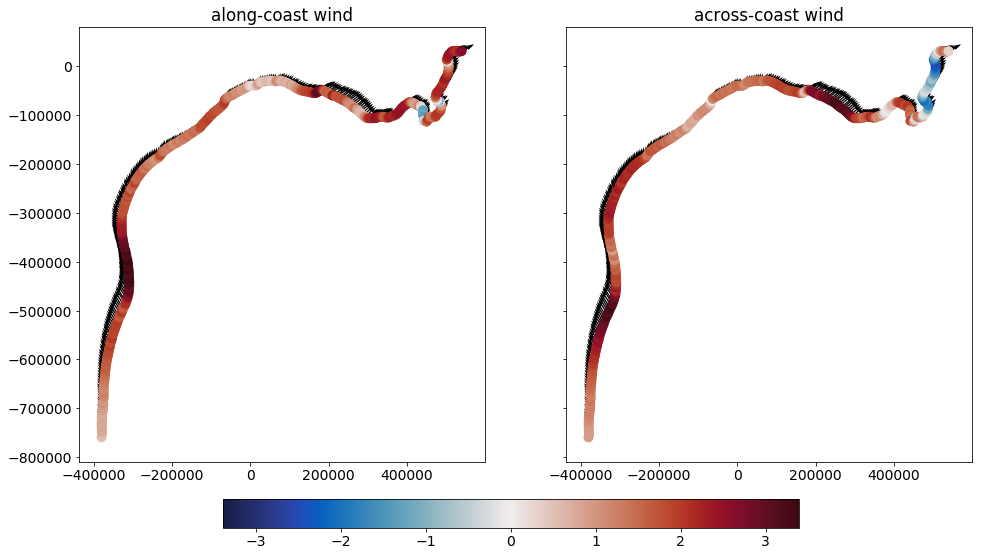

In [131]:
fig, axes = plt.subplots(1,2, figsize=(16,8), sharey=True)
# winds along coast path
axes[0].quiver(xcoast, ycoast, ucoast, vcoast);
vmax = np.nanmax(abs(walong))
axes[0].scatter(xcoast, ycoast, c=walong, s=80, cmap=cmo.balance, vmin=-vmax, vmax=vmax)
axes[0].set_title('along-coast wind')
axes[1].quiver(xcoast, ycoast, ucoast, vcoast);
vmax = np.nanmax(abs(wacross))
mappable = axes[1].scatter(xcoast, ycoast, c=wacross, s=80, cmap=cmo.balance, vmin=-vmax, vmax=vmax)
axes[1].set_title('across-coast wind')
cax = fig.add_axes([0.25,0.01,0.5,0.05])
fig.colorbar(mappable, cax=cax, orientation='horizontal')

Plots arrows without coastline

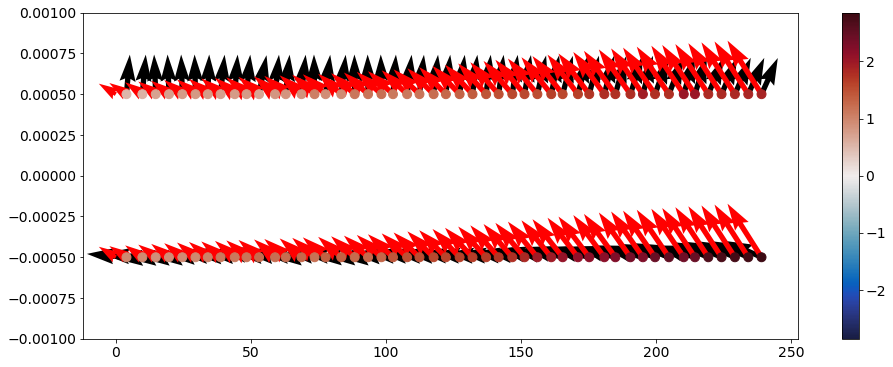

In [133]:
fig, axes = plt.subplots(1,1, figsize=(16,6), sharey=True)

# # winds along coast path
# axes.quiver(xcoast, ycoast, veccoast[:,0], veccoast[:,1]);
# axes.quiver(xcoast, ycoast, ucoast, vcoast);
dd = 50
# walong
axes.quiver(dist[:dd], 0.0005 + np.zeros_like(dist[:dd]), veccoast[:dd,0], veccoast[:dd,1]);
axes.quiver(dist[:dd], 0.0005 + np.zeros_like(dist[:dd]), ucoast[:50], vcoast[:50], color='r');
vmax = np.nanmax((abs(walong[:dd]), abs(wacross[:dd])))
mappable = axes.scatter(dist[:dd], 0.0005 + np.zeros_like(dist[:dd]), s=80, c=walong[:dd], cmap=cmo.balance, vmin=-vmax, vmax=vmax)
# wacross
axes.quiver(dist[:dd], -0.0005 + np.zeros_like(dist[:dd]), veccoast90[:dd,0], veccoast90[:dd,1]);
axes.quiver(dist[:dd], -0.0005 + np.zeros_like(dist[:dd]), ucoast[:50], vcoast[:50], color='r');
# vmax = np.nanmax(abs(wacross[:dd]))
mappable = axes.scatter(dist[:dd], -0.0005 + np.zeros_like(dist[:dd]), s=80, c=wacross[:dd], cmap=cmo.balance, vmin=-vmax, vmax=vmax)
axes.set_ylim(-0.001, 0.001)
fig.colorbar(mappable)

The square root of the squares of `walong` and `wacross` should equal the original wind speed.

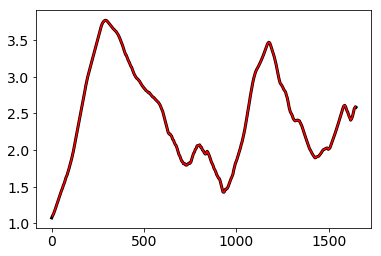

In [135]:
ws = np.sqrt((walong**2) + wacross**2)
s = np.sqrt(ucoast**2 + vcoast**2)
plt.plot(dist, s, 'k', lw=3)
plt.plot(dist, ws, 'r')

Yay it is finally checking out!!!

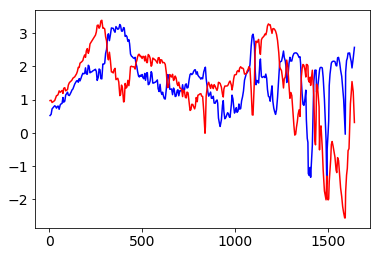

In [138]:

# plt.quiver(dist, np.zeros_like(dist), ucoast, vcoast);
plt.plot(dist, walong, 'blue')
plt.plot(dist, wacross, 'r')

# Production run

In [8]:
vecname = 'calcs/coast_vectors.npz'
d = np.load(vecname)
veccoast = d['veccoast']; veccoast90 = d['veccoast90']

# load in grid
proj = tracpy.tools.make_proj('nwgom-pyproj')
grid = tracpy.inout.readgrid('../../grid.nc', proj)
lon_rho = grid.lon_rho[1:-1,1:-1]
lat_rho = grid.lat_rho[1:-1,1:-1]
x_rho, y_rho = proj(lon_rho, lat_rho)
angle = grid.angle_rho[1:-1,1:-1]  # theta to rotate wind vectors

base = 'calcs/along_coast_wind/'
if not os.path.exists(base):
    os.makedirs(base)
    
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
m = xr.open_dataset(loc)

pts = np.column_stack((x_rho.flatten(), y_rho.flatten()))
tess = Delaunay(pts)
tri = mtri.Triangulation(x_rho.flatten(), y_rho.flatten(), tess.simplices.copy())


In [10]:
# load in coastline as clicked in by coast boxes
outerpathxy = np.load('../calcs/coastpaths.npz', encoding='latin1')['outerpathg'].item()
# # x, y pts for path closest to land
# xcoast = outerpathxy.vertices[:343,0]; ycoast = outerpathxy.vertices[:343,1]
# x, y pts for path farther from land
xgcoast = outerpathxy.vertices[343:-2,0]; ygcoast = outerpathxy.vertices[343:-2,1]
# also flipping so go from MX to LA in order
xgcoast = xgcoast[::-1]; ygcoast = ygcoast[::-1]

# convert from grid coords to xy
xcoast, ycoast, _ = tracpy.tools.interpolate2d(xgcoast, ygcoast, grid, 'm_ij2xy')


In [ ]:
years = np.arange(2004, 2015)

for year in years:
    dates = m['ocean_time'].sel(ocean_time=str(year))
    fname = base + str(year) + '.npz'
    
    if not os.path.exists(fname):

        walong = np.empty((len(dates[::4]), 342)); wacross = np.empty((len(dates[::4]), 342))

        for i, date in enumerate(dates[::4]):
            if np.mod(i,30*24) == 0:  # print every 30 days
                print(date)

            # U and V wind speed on rho grid but without ghost cells
            # u, v are along and across-shore
            u = m.Uwind.sel(ocean_time=date).isel(eta_rho=slice(1,-1), xi_rho=slice(1,-1))
            v = m.Vwind.sel(ocean_time=date).isel(eta_rho=slice(1,-1), xi_rho=slice(1,-1))

            # rotate u, v to be east/north/Cartesian so that I can project properly to coast vectors
            u, v = rot2d(u, v, angle)

            # interpolate wind information onto outerpathxy vertices
            fu = mtri.LinearTriInterpolator(tri, u.data.flatten())
            fv = mtri.LinearTriInterpolator(tri, v.data.flatten())
            ucoast = fu(xcoast, ycoast)  # x-direction wind, at locations along coast
            vcoast = fv(xcoast, ycoast)  # y-direction wind, at locations along coast

            # make vector of wind
            w = np.vstack((ucoast, vcoast))

            # dot product of the two vectors: gives size of along-shore component
            walong[i,:] = np.dot(veccoast, w).diagonal()
            wacross[i,:] = np.dot(veccoast90, w).diagonal()
        np.savez(fname, walong=walong, wacross=wacross, dist=dist, dates=dates.data)

<xarray.DataArray 'ocean_time' ()>
array(1072915200000000000, dtype='datetime64[ns]')
Coordinates:
    ocean_time  datetime64[ns] 2004-01-01
Attributes:
    long_name:    time since initialization
    field:        time, scalar, series
    _ChunkSizes:  524288
<xarray.DataArray 'ocean_time' ()>
array(1083283200000000000, dtype='datetime64[ns]')
Coordinates:
    ocean_time  datetime64[ns] 2004-04-30
Attributes:
    long_name:    time since initialization
    field:        time, scalar, series
    _ChunkSizes:  524288
<xarray.DataArray 'ocean_time' ()>
array(1093651200000000000, dtype='datetime64[ns]')
Coordinates:
    ocean_time  datetime64[ns] 2004-08-28
Attributes:
    long_name:    time since initialization
    field:        time, scalar, series
    _ChunkSizes:  524288
<xarray.DataArray 'ocean_time' ()>
array(1104019200000000000, dtype='datetime64[ns]')
Coordinates:
    ocean_time  datetime64[ns] 2004-12-26
Attributes:
    long_name:    time since initialization
    field:        ti

In [ ]:
d = np.load('calcs/along_coast_wind/2004.npz')
d.keys()

Interactive namespace is empty.


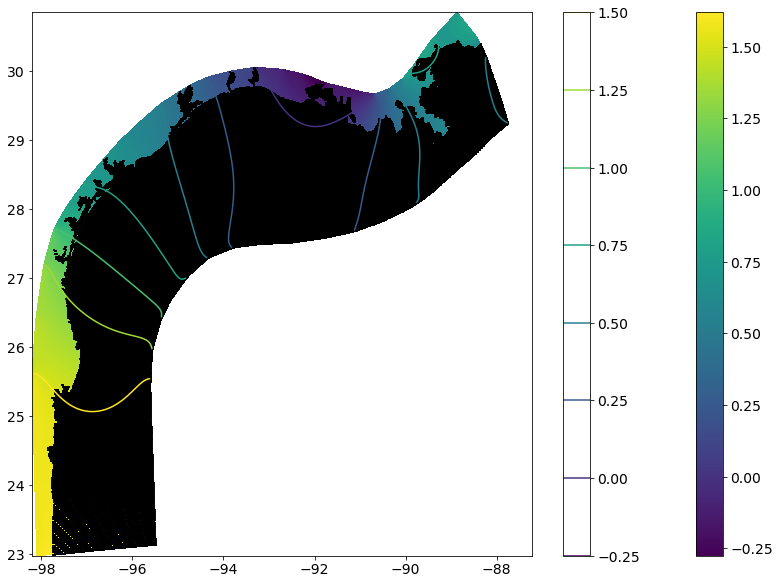

In [10]:
plt.figure(figsize=(14,10))
plt.pcolormesh(lon_rho, lat_rho, angle); plt.colorbar()
# plt.contour(lon_rho, lat_rho, angle); plt.colorbar()
plt.scatter(lon_rho, lat_rho, s=grid.mask_rho[1:-1,1:-1], color='k', marker='s')